In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import warnings 
warnings.filterwarnings('ignore')


In [2]:
os.getcwd()

'/kaggle/working'

In [3]:
# from glob import glob
# data = glob('/kaggle/input/breast-histopathology-images/**/*.png', recursive=True)
# with open(r'/kaggle/working/paths.txt', 'w') as fp:
#     for item in data:
#         # write each item on a new line
#         fp.write("%s\n" % item)
#     print('Done')

In [4]:
with open(r'../input/pathstxt/paths.txt', 'r') as fp:
    total_data = fp.readlines()
    print(len(total_data))

265696


In [5]:
data = total_data[:50000]
len(data)
data[1]
int(data[1].split('/')[-1][-6])

0

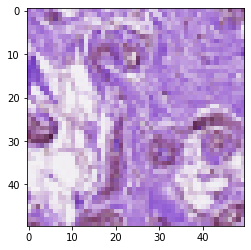

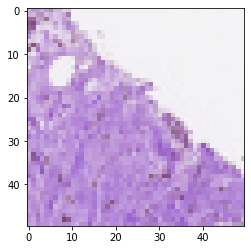

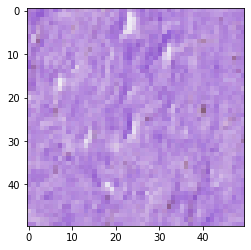

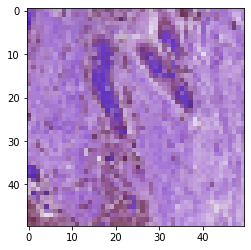

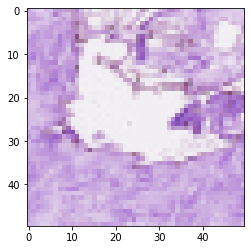

In [6]:
import cv2
import matplotlib.pyplot as plt
for a in data[:5]:
    img=cv2.imread(a.rstrip())
    img_1=cv2.resize(img,(224,224))
    plt.imshow(img,cmap='binary')
    plt.show()

In [7]:
data = pd.DataFrame(data, columns=['image_path'])
data.head()

,image_path
0,/kaggle/input/breast-histopathology-images/102...
1,/kaggle/input/breast-histopathology-images/102...
2,/kaggle/input/breast-histopathology-images/102...
3,/kaggle/input/breast-histopathology-images/102...
4,/kaggle/input/breast-histopathology-images/102...


In [8]:
def extract_image_path(x):
    image_path = x.rstrip()
    return image_path

data['image_path'] = data['image_path'].apply(extract_image_path)

data.head()

,image_path
0,/kaggle/input/breast-histopathology-images/102...
1,/kaggle/input/breast-histopathology-images/102...
2,/kaggle/input/breast-histopathology-images/102...
3,/kaggle/input/breast-histopathology-images/102...
4,/kaggle/input/breast-histopathology-images/102...


In [9]:
def extract_target(x):
    target = x.split('/')[-1][-5]
    return target

data['target'] = data['image_path'].apply(extract_target)

data.head()

,image_path,target
0,/kaggle/input/breast-histopathology-images/102...,0
1,/kaggle/input/breast-histopathology-images/102...,0
2,/kaggle/input/breast-histopathology-images/102...,0
3,/kaggle/input/breast-histopathology-images/102...,0
4,/kaggle/input/breast-histopathology-images/102...,0


In [10]:
def extract_patient_id(x):
    a = x.split('/')[-1].split('_')
    patient_id = a[0]
    
    return patient_id
data['patient_id'] = data['image_path'].apply(extract_patient_id)
data.head()

,image_path,target,patient_id
0,/kaggle/input/breast-histopathology-images/102...,0,10295
1,/kaggle/input/breast-histopathology-images/102...,0,10295
2,/kaggle/input/breast-histopathology-images/102...,0,10295
3,/kaggle/input/breast-histopathology-images/102...,0,10295
4,/kaggle/input/breast-histopathology-images/102...,0,10295


In [11]:
data['target'].value_counts()

0    36456
1    13544
Name: target, dtype: int64

In [12]:
# import os
import numpy as np
import shutil
# import pandas as pd
# from skimage.util import random_noise
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt
# from skimage.filters import gaussian
import seaborn as sns
from sklearn.metrics import confusion_matrix
# import itertools


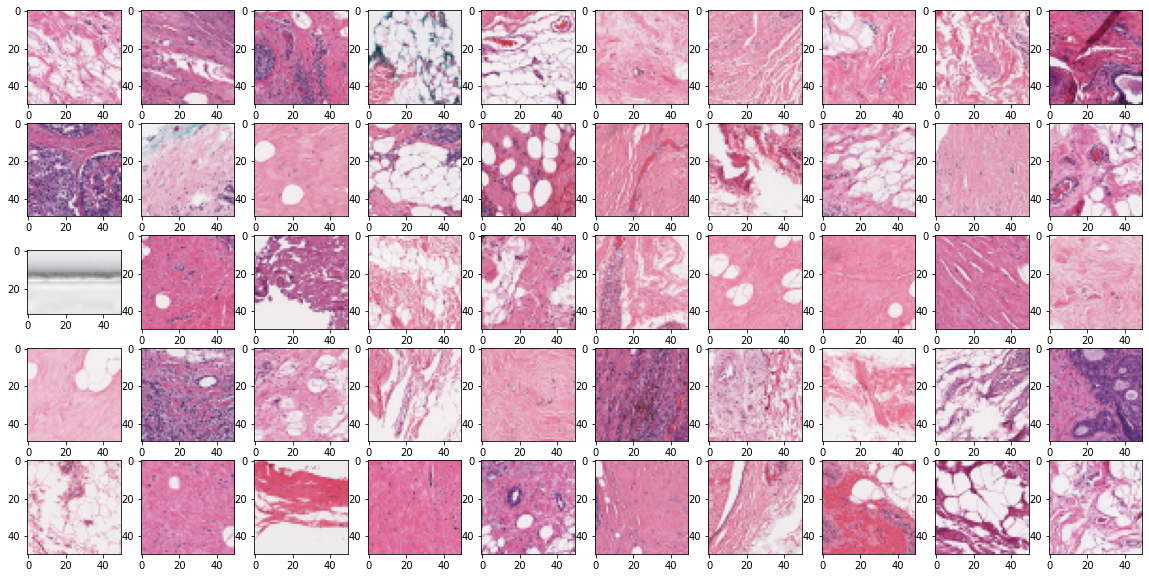

In [13]:
# data.target = data.target.astype(np.int)
fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target =='1'].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target =='0'].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =data.loc[idx, 'image_path']
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


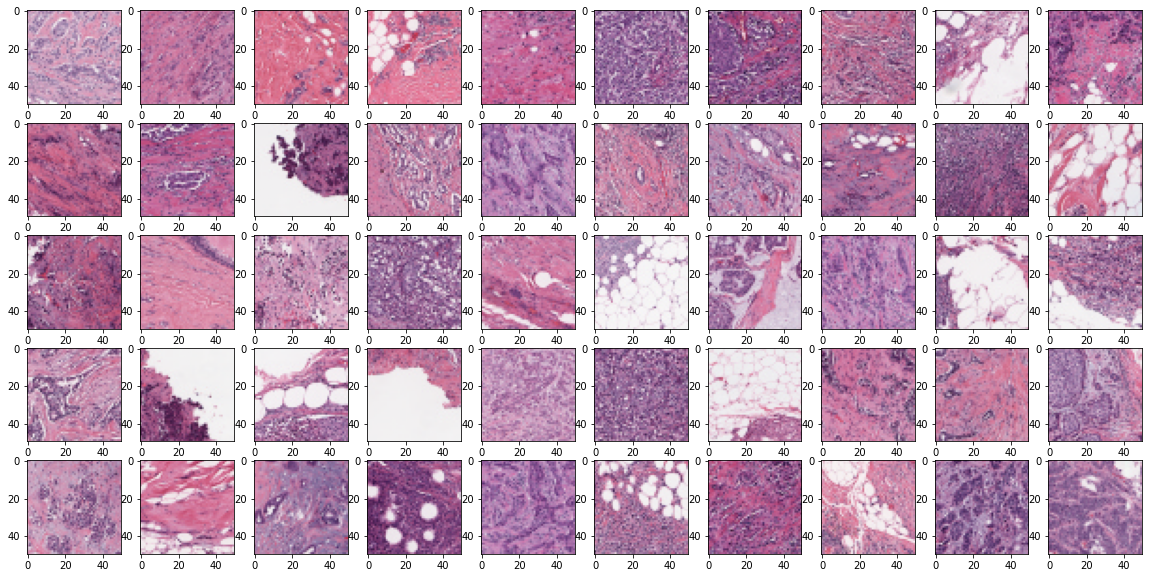

In [14]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =data.loc[idx, 'image_path']
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


Text(0.5, 1.0, 'How many patches show IDC?')

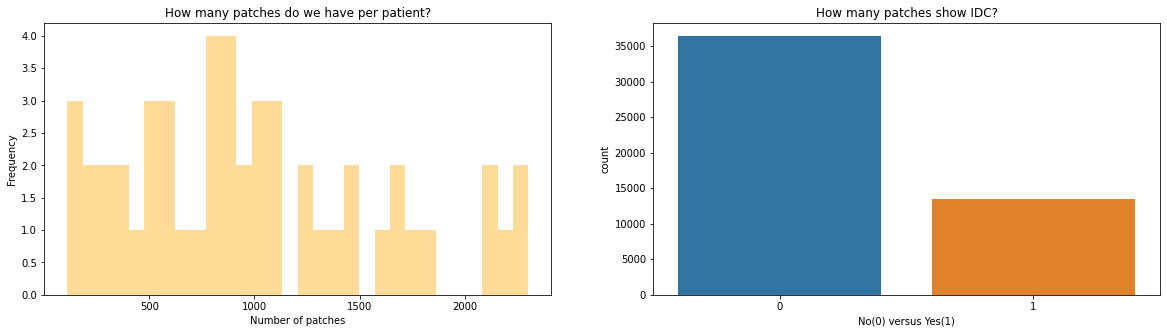

In [15]:

fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")


sns.countplot(data.target, ax=ax[1])
ax[1].set_xlabel("No(0) versus Yes(1)")
ax[1].set_title("How many patches show IDC?")

In [16]:
train, test = train_test_split(data, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

In [17]:
print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (42750, 3)
test set shape: (2500, 3)
validation set shape: (4750, 3)


In [18]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [19]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'image_path', y_col ='target',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'image_path', y_col ='target', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'image_path', y_col ='target',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 42750 validated image filenames belonging to 2 classes.
Found 4750 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [20]:
train_gen.class_indices

{'0': 0, '1': 1}

In [21]:
from tensorflow import keras

base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

2022-06-11 18:25:41.730900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 18:25:41.830818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 18:25:41.831574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 18:25:41.832700: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [22]:
from tensorflow.keras.optimizers import Adam

In [23]:

callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience= 3, verbose= 1, mode= 'auto'),
    tensorflow.keras.callbacks.ModelCheckpoint("Breast_Cancer_classifier_model.h5", save_best_only=True, verbose = 0)
]


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 50, 
                    callbacks = [callbacks], verbose = 1)

2022-06-11 18:25:47.291905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-06-11 18:25:52.087018: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1336/1336 [==============================] - 913s 676ms/step - loss: 0.4470 - accuracy: 0.7979 - val_loss: 0.3639 - val_accuracy: 0.8419
Epoch 2/50
1336/1336 [==============================] - 553s 414ms/step - loss: 0.3810 - accuracy: 0.8364 - val_loss: 0.3531 - val_accuracy: 0.8467
Epoch 3/50
1336/1336 [==============================] - 550s 412ms/step - loss: 0.3695 - accuracy: 0.8413 - val_loss: 0.3483 - val_accuracy: 0.8488
Epoch 4/50
1336/1336 [==============================] - 554s 414ms/step - loss: 0.3600 - accuracy: 0.8450 - val_loss: 0.3389 - val_accuracy: 0.8539
Epoch 5/50
1336/1336 [==============================] - 550s 412ms/step - loss: 0.3554 - accuracy: 0.8473 - val_loss: 0.3433 - val_accuracy: 0.8507
Epoch 6/50
1336/1336 [==============================] - 552s 413ms/step - loss: 0.3547 - accuracy: 0.8462 - val_loss: 0.3347 - val_accuracy: 0.8564
Epoch 7/50
1336/1336 [==============================] - 555s 416ms/step - loss: 0.3532 - accuracy: 0.8495 - val_loss: 0.337

In [24]:
model.save("model.h5")

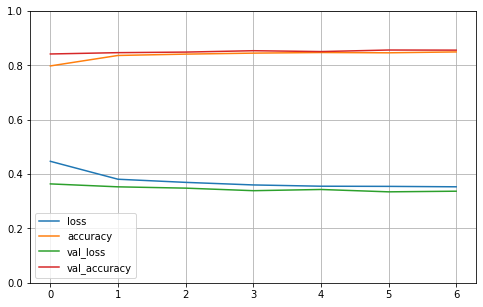

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [26]:
val_loss, val_acc  = model.evaluate_generator(test_gen)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.3282502591609955
val_acc: 0.8600000143051147


In [27]:
from PIL import Image
model_path = r"./model.h5"
loaded_model = tensorflow.keras.models.load_model(model_path)

# import matplotlib.pyplot as plt
import numpy as np
print(total_data[505].rstrip())
image = cv2.imread(total_data[6050].rstrip())

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
print(pred)
if pred >= 0.5:
  print("1")
else:
  print("0")

/kaggle/input/breast-histopathology-images/10295/0/10295_idx5_x801_y1501_class0.png
[[0.4399298]]
0


In [28]:
import warnings 
warnings.filterwarnings('ignore')

In [29]:
# load and evaluate a saved model
import tensorflow
model_path = r"../input/breastcancer/model.h5"
# load model
model = tensorflow.keras.models.load_model(model_path)
# summarize model.
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [30]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)